In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install ipywidgets widgetsnbextension pandas-profiling rich=="10.2.2"
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
!pip install pytorch_lightning
!pip install timm
!pip install pandas
!pip install wandb
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import timm
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet

import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    RichProgressBar,
)
from pytorch_lightning.loggers import WandbLogger
import wandb

from training import UNetModel
from datasets import CamvidDataset
from metrics import CamvidAccuracy
from visualization import visualise

# Config

In [9]:
data_paths = {
    "train": {
        "images": Path("/notebooks/data/CamVid/train/"),
        "masks": Path("/notebooks/data/CamVid/train_labels/")
    },
    "test": {
        "images": Path("/notebooks/data/CamVid/test/"),
        "masks": Path("/notebooks/data/CamVid/test_labels/")
    },
    "val": {
        "images": Path("/notebooks/data/CamVid/val/"),
        "masks": Path("/notebooks/data/CamVid/val_labels/")
    },
}

In [10]:
batch_size = 8
size = (720, 960)
learning_rate = 3e-4

# Preparing datasets and dataloaders

In [11]:
transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2(),
])
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
])

In [12]:
ds_train = CamvidDataset(data_paths["train"]["images"], data_paths["train"]["masks"], transform=transform, augment=augment)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=8)

ds_val = CamvidDataset(data_paths["val"]["images"], data_paths["val"]["masks"], transform=transform)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8)

# Training

In [13]:
unet_pl_model = UNetModel.load_from_checkpoint("/notebooks/checkpoints/unet-epoch=19-val_loss=0.52.ckpt", size=size, learning_rate=3e-4)
# unet_pl_model = UNetModel(size=size, learning_rate=3e-4)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='unet-{epoch:02d}-{val_acc:.2f}'
)
early_stopping_callback = EarlyStopping(
    monitor="val_acc",
    min_delta=0.0,
    patience=3,
    mode="max",
)
# wandb_logger = WandbLogger(project="camvid")

In [ ]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=20,
    callbacks=[checkpoint_callback, early_stopping_callback, RichProgressBar()],
#     logger=wandb_logger,
#     auto_lr_find=True,
)

In [ ]:
# trainer.tune(unet_pl_model, loaders["train"], loaders["val"])

In [ ]:
trainer.fit(unet_pl_model, dl_train, dl_val)

# Visualisation

In [14]:
unet_pl_model = UNetModel.load_from_checkpoint("/notebooks/checkpoints/unet-epoch=08-val_acc=0.92.ckpt", size=size)

In [15]:
ds_test = CamvidDataset(data_paths["test"]["images"], data_paths["test"]["masks"], transform=transform)
dl_test = DataLoader(ds_test, batch_size=1, shuffle=False, drop_last=False, num_workers=8)

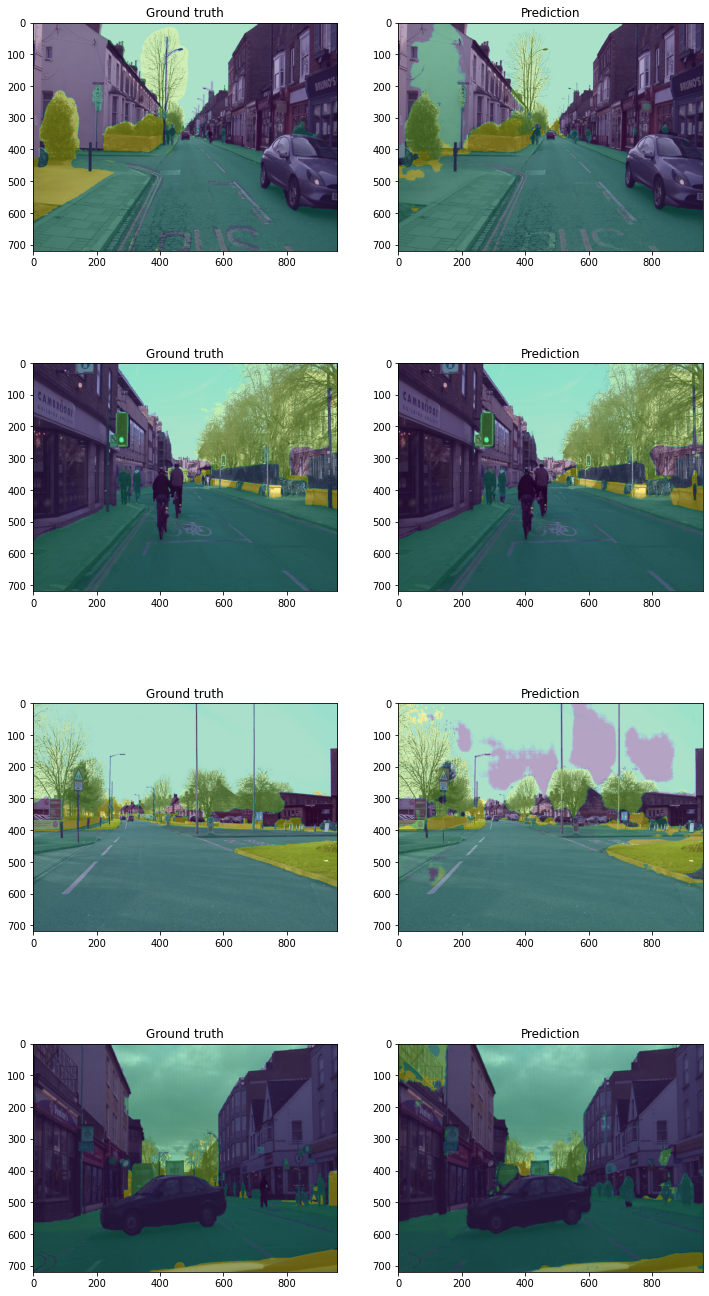

In [16]:
visualise(unet_pl_model, dl_test, 4)